In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
 
train_pickle ='/content/drive/My Drive/Colab Data/riiid/lgb_train.p'
valid_pickle = '/content/drive/My Drive/Colab Data/riiid/lgb_valid.p'
 
train = pd.read_pickle(train_pickle)
valid = pd.read_pickle(valid_pickle)

ROC for XGBoost model
0.7618601217008342


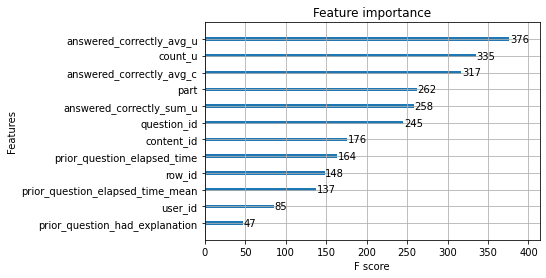

In [3]:
from sklearn.metrics import roc_auc_score
 
FEATS = ['row_id', 'user_id', 'content_id', 'content_type_id',
       'prior_question_elapsed_time',
       'prior_question_had_explanation', 'answered_correctly_sum_u', 'count_u',
       'answered_correctly_avg_u', 'answered_correctly_avg_c',
       'prior_question_elapsed_time_mean', 'question_id', 'part']
 
TARGET = ['answered_correctly']
 
X_train = train[FEATS]
y_train = train[TARGET]
X_valid = valid[FEATS]
y_valid = valid[TARGET]


import xgboost
from xgboost import XGBClassifier
from xgboost import plot_importance

params = {
    'max_depth' : 12,
    'max_leaves' : 2**8,
    'eta':0.6,  # Step size shrinkage used in update to prevents overfitting
                # After each boosting step, we can directly get the weights of 
    # new features, and eta shrinks the feature weights to make the boosting 
    # process more conservative.
    'alpha':0.1,     # L1 regularization term on weights. 
    'lambda' : 0.2,  # L2 regularization term on weights. 
                     # Increasing this value will make model more conservative.
    'min_child_weight':1,
    'subsample':0.8,  # default = 1, Subsample ratio of the training instances. 
                      # Setting it to 0.5 means that XGBoost would randomly 
                      # sample half of the training data prior to growing trees.
                      # l prevent overfitting. 
                      # Subsampling will occur once in every boosting iteration.
    'tree_method' : 'gpu_hist',
    'learning_rate': 0.5, #default = 0.3,
    'colsample_bytree':0.7, # is the subsample ratio of columns when constructing each tree. 
                            # Subsampling occurs once for every tree constructed.
    'eval_metric':'auc', 
    'objective' : 'binary:logistic',
    'sample_type': 'weighted',
    'grow_policy' : 'lossguide',
    'n_estimators': 200,
    'normalize_type': 'tree',
    'rate_drop': 0.2,    # dropout rate 
    'skip_drop': 0.1,    # probability of skipping dropout (If a dropout is 
                         # skipped, new trees are added in the same manner as gbtree.)
    'feature_selector':'thrifty',  # This operation is multithreaded and is a 
    # linear complexity approximation of the quadratic greedy selection. 
    'deterministic_histogram': 'true',  # Histogram building is not deterministic 
    # due to the non-associative aspect of floating point summation. We employ a 
    # pre-rounding routine to mitigate the issue, which may lead to slightly lower 
    # accuracy
    # 'booster' : 'dart'
    'single_precision_histogram':'true', # single precision to build histograms instead of double precision
    'sampling_method':'gradient_based', # only supported when tree_method is set to gpu_hist    
    'predictor': 'gpu_predictor'

}

num_round = 50
train_matrix = xgboost.DMatrix(data = train[FEATS], label =  train[TARGET])
test_matrix = xgboost.DMatrix(data = valid[FEATS])
xgb = xgboost.train(params, dtrain = train_matrix)

predicts = xgb.predict(test_matrix, ntree_limit=num_round)
roc = roc_auc_score(valid[TARGET].astype('int32'), predicts)
print('ROC for XGBoost model')
print(roc)
plot_importance(xgb)